In [1]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "In the midst of winter, "

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])



BASE_CONFIG

{'vocab_size': 50257,
 'context_length': 1024,
 'drop_rate': 0.0,
 'qkv_bias': True,
 'emb_dim': 768,
 'n_layers': 12,
 'n_heads': 12}

# 1. GPT2 Architecture

## 1.1

- Let's load:
  1. `MultiHeadAttention` class
  2. `LayerNorm` class
  3. `GELU` class
  4. `FeedForward` class
  5. `TransformerBlock` class
  6. `GPT2Model` class

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import tiktoken


class MultiHeadAttention(nn.Module):
    def __init__(self,
                 input_embedding_dim,
                 output_embedding_dim,
                 context_length,
                 dropout,
                 num_heads,
                 qkv_bias=False):
        super().__init__()
        assert (output_embedding_dim % num_heads == 0), \
            "output_embedding_dim must be divisible by num_heads"

        self.output_embedding_dim = output_embedding_dim
        self.num_heads = num_heads
        self.head_dim = output_embedding_dim // num_heads
        self.W_query = nn.Linear(input_embedding_dim, output_embedding_dim,
                                 bias=qkv_bias)
        self.W_key = nn.Linear(input_embedding_dim, output_embedding_dim,
                               bias=qkv_bias)
        self.W_value = nn.Linear(input_embedding_dim, output_embedding_dim,
                                 bias=qkv_bias)
        self.output_projection = nn.Linear(output_embedding_dim,
                                           output_embedding_dim)  # to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1))

    def forward(self, inputs):
        batch, num_tokens, input_embedding_dim = inputs.shape

        # qkv shapes : (batch, num_tokens, output_embedding_dim)
        keys = self.W_key(inputs)
        values = self.W_value(inputs)
        queries = self.W_query(inputs)

        # qkv shapes : (batch, num_tokens, num_heads, head_dim)
        keys = keys.view(batch, num_tokens, self.num_heads, self.head_dim)
        values = values.view(batch, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(batch, num_tokens, self.num_heads, self.head_dim)

        # qkv shapes : (batch, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        values = values.transpose(1, 2)
        queries = queries.transpose(1, 2)

        # compute attention scores for each head
        attention_scores = queries @ keys.transpose(3, 2)
        attention_scores.masked_fill_(
            self.mask.bool()[:num_tokens, :num_tokens], - torch.inf)

        # compute attention weights + dropout
        masked_attention_weight = torch.softmax(
            attention_scores / (keys.shape[-1] ** 0.5),
            dim=-1)
        masked_attention_dropout_weight = self.dropout(masked_attention_weight)

        # compute context vectors
        # shape : (batch, num_tokens, num_heads, head_dim)
        context_vector = (masked_attention_dropout_weight @ values).transpose(1, 2)

        # combine heads, where self.d_out = self.num_heads * self.head_dim
        # shape : (batch, num_tokens, output_embedding_dim)
        context_vector = context_vector.contiguous().view(
            batch, num_tokens, self.output_embedding_dim)

        # linear projection (optional)
        context_vector = self.output_projection(context_vector)

        return context_vector


class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.epsilon = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1,
                    unbiased=False,  # Bessel's correction (n-1)
                    keepdim=True)
        norm_x = (x - mean) / torch.sqrt(var + self.epsilon)
        return self.scale * norm_x + self.shift


class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))


class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(config["emb_dim"],  # 768
                      4 * config["emb_dim"]),  # 3072
            GELU(),  # 3072
            nn.Linear(4 * config["emb_dim"],  # 3072
                      config["emb_dim"])  # 768
        )

    def forward(self, x):
        return self.layers(x)


class TransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attention = MultiHeadAttention(input_embedding_dim=config["emb_dim"],
                                            output_embedding_dim=config["emb_dim"],
                                            context_length=config["context_length"],
                                            dropout=config["drop_rate"],
                                            num_heads=config["n_heads"],
                                            qkv_bias=config["qkv_bias"])
        self.feed_forward = FeedForward(config)
        self.layer_norm1 = LayerNorm(config["emb_dim"])
        self.layer_norm2 = LayerNorm(config["emb_dim"])
        self.drop_skip = nn.Dropout(config["drop_rate"])

    def forward(self, x):
        # skip connection for attention block
        shortcut = x
        x = self.layer_norm1(x)
        x = self.attention(x)  # shape: [batch_size, num_tokens, emb_size]
        x = self.drop_skip(x)
        x = shortcut + x  # skip connection

        # skip connection for feed forward block
        shortcut = x
        x = self.layer_norm2(x)
        x = self.feed_forward(x)
        x = self.drop_skip(x)
        x = shortcut + x  # skip connection

        return x


class GPT2Model(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.token_emb = nn.Embedding(config["vocab_size"],
                                      config["emb_dim"])
        self.position_emb = nn.Embedding(config["context_length"],
                                         config["emb_dim"])
        self.drop_emb = nn.Dropout(config["drop_rate"])

        self.transformer_blocks = nn.Sequential(
            *[TransformerBlock(config) for _ in range(config["n_layers"])])

        self.final_norm = LayerNorm(config["emb_dim"])

        self.out_head = nn.Linear(config["emb_dim"],
                                  config["vocab_size"],
                                  bias=False)

    def forward(self, input_token):
        batch_size, sequence_length = input_token.shape
        token_embeds = self.token_emb(input_token)
        position_embeds = self.position_emb(
            torch.arange(sequence_length,
                         device=input_token.device))
        embeds = token_embeds + position_embeds
        x = self.drop_emb(embeds)
        x = self.transformer_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits




class GPT2DatasetV1(Dataset):
  def __init__(self,
               text,
               tokenizer,
               context_length, # length of each input vector
               stride # chunk the text into overlapping sequence of context_length
               ):
    self.input_id_vectors = []
    self.target_id_vectors = []

    # tokenize the entire text
    token_list = tokenizer.encode(text)

    # append input and target vectors
    for i in range(0, len(token_list) - context_length, stride):
      input_vector = token_list[i:i+context_length]
      target_vector = token_list[i+1:i+context_length+1]
      self.input_id_vectors.append(torch.tensor(input_vector))
      self.target_id_vectors.append(torch.tensor(target_vector))

  # get the number of input vectors
  def __len__(self):
    return len(self.input_id_vectors)

  # return the (input vector, target vector) pair
  def __getitem__(self, id):
    return self.input_id_vectors[id], self.target_id_vectors[id]



def create_dataloader_V1(text,
                 batch_size=4,
                 context_length=256,
                 stride=128,
                 shuffle=True, # shuffle dataset
                 drop_last=True, # drop last batch if it not equal required size
                 num_workers=0 # number of CPU processes for preprocessing
                 ):

  tokenizer = tiktoken.get_encoding("gpt2")

  dataset = GPT2DatasetV1(text=text,
                          tokenizer=tokenizer,
                          context_length=context_length,
                          stride=stride)

  dataloader = DataLoader(dataset=dataset,
                          batch_size=batch_size,
                          shuffle=shuffle,
                          drop_last=drop_last,
                          num_workers=num_workers)

  return dataloader

## 1.2 Training and Evaluation Functions

- Let's load:
  1. `train_model_simple`: without warmup rate, cosine decay, gradient clipping
  2. `train_model`
  3. `evaluate_model`

In [3]:
import torch
import math




def train_model_simple(model,
                       train_loader,
                       val_loader,
                       optimizer,
                       device,
                       num_epochs,
                       eval_freq,
                       eval_iter,
                       start_context,
                       tokenizer):

  # initialize lists to track losses and tokens seen
  train_losses = []
  val_losses = []
  track_tokens_seen = []
  token_seen = 0
  global_step = -1

  # main training loop - iterate over training epochs
  for epoch in range(num_epochs):
    # set model to training mode
    model.train()

    # iterate over batches in each training epoch
    for input_batch, target_batch in train_loader:
      # reset loss gradients from previous batch iteration
      optimizer.zero_grad()

      # calculate loss on current batch
      loss = calc_loss_batch(input_batch,
                             target_batch,
                             model,
                             device)

      # backward pass to calculate loss gradients
      loss.backward()

      # update model weights using loss gradients
      optimizer.step()
      token_seen += input_batch.numel()
      global_step += 1

      # optional evaluation step
      if global_step % eval_freq == 0:
        train_loss, val_loss = evaluate_model(model,
                                              train_loader,
                                              val_loader,
                                              device,
                                              eval_iter)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        track_tokens_seen.append(token_seen)
        # print training and evaluation set loss
        print(f"Ep {epoch+1} (Step {global_step:06d}): "
              f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

    # generative sample text for visual inspection
    generate_and_print_sample(model,
                              tokenizer,
                              device,
                              start_context)

  return train_losses, val_losses, track_tokens_seen






ORIG_BOOK_VERSION = False
def train_model(model,
                train_loader,
                val_loader,
                optimizer,
                device,
                n_epochs,
                eval_freq,
                eval_iter,
                start_context,
                tokenizer,
                warmup_steps,
                initial_lr=3e-05,
                min_lr=1e-6):

  train_losses, val_losses = [], []
  track_tokens_seen, track_lrs = [], []

  token_seen = 0
  global_step = -1

  # retrieve the maximum/peak learning rate from the optimizer
  peak_lr = optimizer.param_groups[0]["lr"]

  # calculate the total number of iterations in the training process
  total_training_steps = len(train_loader) * n_epochs

  # calculate the learning rate increment during the warmup phase
  lr_increment = (peak_lr - initial_lr) / warmup_steps

  for epoch in range(n_epochs):
    model.train()
    for input_batch, target_batch in train_loader:
      optimizer.zero_grad()
      global_step += 1

      # adjust the learning rate based on the current phase (warmup or cosine)
      if global_step < warmup_steps:
        lr = initial_lr + global_step * lr_increment
      else:
        # cosine annealing after warmup
        progress = ((global_step - warmup_steps) /
                    (total_training_steps - warmup_steps))
        lr = (min_lr +
         (peak_lr - min_lr) * 0.5 * (1 + math.cos(math.pi * progress)))

      # apply the calculated learning rate to the optimizer
      for param_group in optimizer.param_groups:
        param_group["lr"] = lr
      track_lrs.append(lr) # store the current learning rate

      # calculate and backpropagate the loss
      loss = calc_loss_batch(input_batch,
                             target_batch,
                             model,
                             device)
      loss.backward()

      # apply gradient clipping after the warmup phase to avoid exploding gradients
      if ORIG_BOOK_VERSION:
        if global_step > warmup_steps:
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
      else:
        # the book originally used global_step > warmup_steps, which led to a skipped clipping step after warmup
        if global_step >= warmup_steps:
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

      optimizer.step()
      token_seen += input_batch.numel()

      # periodically evaluate the model on the training and validation sets
      if global_step % eval_freq == 0:
        train_loss, val_loss = evaluate_model(model,
                                              train_loader,
                                              val_loader,
                                              device,
                                              eval_iter)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        track_tokens_seen.append(token_seen)
        # print the current losses
        print(f"Ep {epoch+1} (Iter {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, "
                      f"Val loss {val_loss:.3f}")

    # generate and print a sample from the model to monitor progess
    generate_and_print_sample(
        model=model,
        tokenizer=tokenizer,
        device=device,
        start_context=start_context
    )

  return train_losses, val_losses, track_tokens_seen, track_lrs







def evaluate_model(model,
                    train_loader,
                    val_loader,
                    device,
                    eval_iter):
  # set model to evaluation mode
  model.eval()
  with torch.no_grad():
    # calculate loss
    train_loss = calc_loss_loader(train_loader,
                                  model,
                                  device,
                                  num_batches=eval_iter)
    val_loss = calc_loss_loader(val_loader,
                                model,
                                device,
                                num_batches=eval_iter)

  # set model back to training mode
  model.train()
  return train_loss, val_loss







############################### utils functions #############################
############################### utils functions #############################
############################### utils functions #############################
############################### utils functions #############################
############################### utils functions #############################


def calc_loss_batch(input_batch,
                    target_batch,
                    model,
                    device):
  input_batch = input_batch.to(device)
  target_batch = target_batch.to(device)

  logits = model(input_batch)
  loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1),
                                           target_batch.flatten())
  return loss


def calc_loss_loader(dataloader,
                     model,
                     device,
                     num_batches=None):
  total_loss = 0.
  if len(dataloader) == 0:
    return float("nan")
  elif num_batches is None:
    num_batches = len(dataloader)
  else:
    # reduce the number of batches to match the total number of batches in the data loader
    # if num_batches exceeds the number of batches in the data loader
    num_batches = min(num_batches, len(dataloader))
  for i, (input_batch, target_batch) in enumerate(dataloader):
    if i < num_batches:
      loss = calc_loss_batch(input_batch,
                             target_batch,
                             model,
                             device)
      total_loss += loss.item()
    else:
      break
  return total_loss / num_batches



def generate_and_print_sample(model,
                              tokenizer,
                              device,
                              start_context):
  # set model to evaluation mode
  model.eval()
  context_size = model.position_emb.weight.shape[0]
  encoded = text_to_token_ids(start_context, tokenizer).to(device)
  with torch.no_grad():
    token_ids = generate_text_simple(model=model,
                                     input_batch=encoded,
                                     max_new_tokens=50,
                                     context_size=context_size)
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " ")) # compact print format
  # set model back to training mode
  model.train()




def text_to_token_ids(text, tokenizer):
  encoded = tokenizer.encode(text, allowed_special={"<|endoftext|>"})

  # turn the list of token IDs into tensor with batch dimension
  encoded_tensor = torch.tensor(encoded).unsqueeze(0)
  return encoded_tensor

def token_ids_to_text(encoded_tensor, tokenizer):
  # turn tensor without batch dimension to list
  token_ids = encoded_tensor.squeeze(0).tolist()
  text = tokenizer.decode(token_ids)
  return text




def generate_text_simple(model,
                         input_batch,  # [batch, num_tokens]
                         max_new_tokens,  # numbers of new tokens to be predicted
                         context_size):
    for _ in range(max_new_tokens):
        # crop current context if it exceeds the supported context_size
        crop_input_batch = input_batch[:, -context_size:]

        # predict next token
        with torch.no_grad():
            logits = model(crop_input_batch)

        # consider only logits of the last token
        logits = logits[:, -1, :]  # (batch, n_tokens, vocab_size) -> (batch, vocab_size)
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)
        predicted_tokens = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)
        # update input_batch (append predicted tokens to the sequences)
        input_batch = torch.cat([input_batch, predicted_tokens], dim=-1)  # [batch, num_tokens+1]

    return input_batch



def generate_text(model,
                  input_batch,
                  max_new_tokens,
                  context_size,
                  temperature=0.0,
                  top_k=None,
                  eos_id=None):
  for _ in range(max_new_tokens):
    # crop current context if it exceeds the supported context_size
    crop_input_batch = input_batch[:, -context_size:]

    # predict next token
    with torch.no_grad():
      logits = model(crop_input_batch)

    # consider only logits of the last token
    logits = logits[:, -1, :] # (batch, n_tokens, vocab_size) -> (batch, vocab_size)

    # NEW: filter logits with top_k sampling
    if top_k is not None:
      # keep only top_k values
      top_logits, _ = torch.topk(logits, top_k)
      min_val = top_logits[:, -1] # min value among the top_k values
      # all values other than top_k values will be set to -inf
      logits = torch.where(logits < min_val,
                           torch.tensor(-torch.inf).to(logits.device),
                           logits)

    # NEW: temperature scaling
    if temperature > 0.0:
      logits = logits / temperature

      probas = torch.softmax(logits, dim=-1) # (batch, vocab_size)
      predicted_tokens = torch.multinomial(probas, num_samples=1) # (batch, 1)

    else: # same as before
      #probas = torch.softmax(logits, dim=-1) # (batch, vocab_size)
      predicted_tokens = torch.argmax(logits, dim=-1, keepdim=True) # (batch, 1)

    if predicted_tokens == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

    # update input_batch (append predicted tokens to the sequences)
    input_batch = torch.cat([input_batch, predicted_tokens], dim=1) # [batch, num_tokens+1]

  return input_batch
############################### utils functions #############################
############################### utils functions #############################
############################### utils functions #############################
############################### utils functions #############################
############################### utils functions #############################

## 1.3 LoRA layer

In [4]:
import math
import torch

class LoRALayer(torch.nn.Module):
  def __init__(self, in_dim, out_dim, rank, alpha):
    super().__init__()
    self.A = torch.nn.Parameter(torch.empty(in_dim, rank))
    # Kaiming/He uniform initialization, similar to standard weight initialization
    torch.nn.init.kaiming_uniform_(self.A, a=math.sqrt(5))
    self.B = torch.nn.Parameter(torch.zeros(rank, out_dim))
    self.alpha = alpha

  def forward(self, x):
    x = self.alpha * (x @ self.A @ self.B)
    return x


class LinearLayerWithLoRA(torch.nn.Module):
  def __init__(self, linear, rank, alpha):
    super().__init__()
    self.linear = linear
    self.lora = LoRALayer(linear.in_features,
                          linear.out_features,
                          rank,
                          alpha)

  def forward(self, x):
    return self.linear(x) + self.lora(x)



def replace_linear_with_lora(model, rank, alpha):
  for name, module in model.named_children():
    if isinstance(module, torch.nn.Linear):
      print(f"Replacing {name} with LinearLayerWithLoRA")
      setattr(model, name, LinearLayerWithLoRA(module, rank, alpha))
    else:
      # recursively apply the same function to child modules
      replace_linear_with_lora(module, rank, alpha)

## 1.4 Load weights

In [5]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))





import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.position_emb.weight = assign(gpt.position_emb.weight, params['wpe'])
    gpt.token_emb.weight = assign(gpt.token_emb.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.transformer_blocks[b].attention.W_query.weight = assign(
            gpt.transformer_blocks[b].attention.W_query.weight, q_w.T)
        gpt.transformer_blocks[b].attention.W_key.weight = assign(
            gpt.transformer_blocks[b].attention.W_key.weight, k_w.T)
        gpt.transformer_blocks[b].attention.W_value.weight = assign(
            gpt.transformer_blocks[b].attention.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.transformer_blocks[b].attention.W_query.bias = assign(
            gpt.transformer_blocks[b].attention.W_query.bias, q_b)
        gpt.transformer_blocks[b].attention.W_key.bias = assign(
            gpt.transformer_blocks[b].attention.W_key.bias, k_b)
        gpt.transformer_blocks[b].attention.W_value.bias = assign(
            gpt.transformer_blocks[b].attention.W_value.bias, v_b)

        gpt.transformer_blocks[b].attention.output_projection.weight = assign(
            gpt.transformer_blocks[b].attention.output_projection.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.transformer_blocks[b].attention.output_projection.bias = assign(
            gpt.transformer_blocks[b].attention.output_projection.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.transformer_blocks[b].feed_forward.layers[0].weight = assign(
            gpt.transformer_blocks[b].feed_forward.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.transformer_blocks[b].feed_forward.layers[0].bias = assign(
            gpt.transformer_blocks[b].feed_forward.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.transformer_blocks[b].feed_forward.layers[2].weight = assign(
            gpt.transformer_blocks[b].feed_forward.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.transformer_blocks[b].feed_forward.layers[2].bias = assign(
            gpt.transformer_blocks[b].feed_forward.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.transformer_blocks[b].layer_norm1.scale = assign(
            gpt.transformer_blocks[b].layer_norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.transformer_blocks[b].layer_norm1.shift = assign(
            gpt.transformer_blocks[b].layer_norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.transformer_blocks[b].layer_norm2.scale = assign(
            gpt.transformer_blocks[b].layer_norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.transformer_blocks[b].layer_norm2.shift = assign(
            gpt.transformer_blocks[b].layer_norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

## 1.5 Dataset
- We'll use `war-and-peace.txt` dataset

# 2. Gradio app

## 2.1 Finetune

In [6]:
# --- Clean up GPU memory ---
import gc
# del train_loss, val_loss  # if you don't need them anymore
#del train_dataloader, val_dataloader  # optional, if not reused
gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [7]:
import urllib.request
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    # Downloading the file
    with urllib.request.urlopen(url) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    # Unzipping the file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    # Add .tsv file extension
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

try:
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)
except (urllib.error.HTTPError, urllib.error.URLError, TimeoutError) as e:
    print(f"Primary URL failed: {e}. Trying backup URL...")
    url = "https://f001.backblazeb2.com/file/LLMs-from-scratch/sms%2Bspam%2Bcollection.zip"
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

File downloaded and saved as sms_spam_collection/SMSSpamCollection.tsv


In [8]:
import pandas as pd

df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [9]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


In [10]:
import numpy as np

def create_balanced_dataset(df):
  # count the instances of `spam`
  num_spam = df[df["Label"] == "spam"].shape[0]

  # randomly sub-sample "ham" with `num_spam` rows
  ham_sub = df[df["Label"] == "ham"].sample(num_spam, random_state=123)

  # concatenate subsets
  balanced_df = pd.concat([ham_sub, df[df["Label"] == "spam"]])

  return balanced_df


balanced_df = create_balanced_dataset(df)

# show first 5 and last 5 rows
print(balanced_df.iloc[np.r_[0:5, -5:0]])

# check label/class distribution
print(balanced_df["Label"].value_counts())

     Label                                               Text
4307   ham  Awww dat is sweet! We can think of something t...
4138   ham                             Just got to  &lt;#&gt;
4831   ham  The word "Checkmate" in chess comes from the P...
4461   ham  This is wishing you a great day. Moji told me ...
5440   ham      Thank you. do you generally date the brothas?
5537  spam  Want explicit SEX in 30 secs? Ring 02073162414...
5540  spam  ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547  spam  Had your contract mobile 11 Mnths? Latest Moto...
5566  spam  REMINDER FROM O2: To get 2.50 pounds free call...
5567  spam  This is the 2nd time we have tried 2 contact u...
Label
ham     747
spam    747
Name: count, dtype: int64


In [11]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

# show first 5 and last 5 rows
print(balanced_df.iloc[np.r_[0:5, -5:0]])

      Label                                               Text
4307      0  Awww dat is sweet! We can think of something t...
4138      0                             Just got to  &lt;#&gt;
4831      0  The word "Checkmate" in chess comes from the P...
4461      0  This is wishing you a great day. Moji told me ...
5440      0      Thank you. do you generally date the brothas?
5537      1  Want explicit SEX in 30 secs? Ring 02073162414...
5540      1  ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547      1  Had your contract mobile 11 Mnths? Latest Moto...
5566      1  REMINDER FROM O2: To get 2.50 pounds free call...
5567      1  This is the 2nd time we have tried 2 contact u...


In [12]:
def random_split(df, train_frac, validation_frac):

  # shuffle dataset
  df = df.sample(frac=1, random_state=211).reset_index(drop=True)

  # compute split range
  train_end = int(len(df) * train_frac)
  validation_end = train_end + int(len(df) * validation_frac)

  # split
  train_df = df[:train_end]
  validation_df = df[train_end:validation_end]
  test_df = df[validation_end:]

  return train_df, validation_df, test_df


train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)


# save splitted dataframe into csv files
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

In [13]:
import torch
from torch.utils.data import Dataset

class SpamDataset(Dataset):
  def __init__(self,
               csv_file,
               tokenizer,
               max_length=None,
               pad_token_id=50256):
    self.data = pd.read_csv(csv_file)

    # pre-tokenizer texts
    self.encoded_texts = [tokenizer.encode(text) for text in self.data["Text"]]

    if max_length is None:
      self.max_length = self._longest_encoded_length()
    else:
      self.max_length = max_length
      # truncate sequences if they're longer than max_length
      self.encoded_texts = [encoded_text[:self.max_length] for encoded_text in self.encoded_texts]

    # pad tokens
    self.encoded_texts = [
        encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
        for encoded_text in self.encoded_texts
    ]


  def __getitem__(self, index):
    encoded_sequence = self.encoded_texts[index]
    label = self.data.iloc[index]["Label"]
    return (
        torch.tensor(encoded_sequence, dtype=torch.long),
        torch.tensor(label, dtype=torch.long)
    )

  def __len__(self):
    return len(self.data)

  def _longest_encoded_length(self):
    return max(len(encoded_text) for encoded_text in self.encoded_texts)

In [14]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

In [15]:
train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer
)

print(train_dataset.max_length)

val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

120


In [16]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(211)


train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

In [17]:
print("Train loader:")
for input_batch, target_batch in train_loader:
    pass

print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

Train loader:
Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])


In [18]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


In [19]:
import urllib.request

url = (
    "https://raw.githubusercontent.com/rasbt/"
    "LLMs-from-scratch/main/ch05/"
    "01_main-chapter-code/gpt_download.py"
)
filename = url.split("/")[-1]
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x7d8486cd9c50>)

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
model_size

'124M'

In [22]:
from gpt_download import download_and_load_gpt2

settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")
print(settings)
print(params.keys())

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 193kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:01<00:00, 695kiB/s]
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 157kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [02:08<00:00, 3.86MiB/s]
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 8.66MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:01<00:00, 403kiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:01<00:00, 390kiB/s]


{'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [23]:
model = GPT2Model(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

In [24]:
text_1 = "In the midst of winter"

token_ids = generate_text(
    model=model,
    input_batch=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=50,
    context_size=BASE_CONFIG["context_length"],
    temperature = 2.0,
    top_k = 10
)

print(token_ids_to_text(token_ids, tokenizer))

In the midst of winter break I was sitting with two friends who I would call friends and would say 'I love you so so much. It's been really nice to see that you guys care.' It's been really nice for the rest of us." She's not exactly


In [25]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)

token_ids = generate_text(
    model=model,
    input_batch=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner


In [26]:
for param in model.parameters():
    param.requires_grad = False

In [27]:
torch.manual_seed(211)

num_classes = 2
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)

In [28]:
for param in model.transformer_blocks[-1].parameters():
    param.requires_grad = True

for param in model.final_norm.parameters():
    param.requires_grad = True

In [29]:
!pip install torchinfo

In [30]:
from torchinfo import summary

summary(
    model,
    input_size=(1, BASE_CONFIG["context_length"]),      # (batch, seq_len)
    dtypes=[torch.long],                                # token IDs are int64
    col_names=("input_size", "output_size", "num_params", "trainable"),
    row_settings=("depth", "var_names"),                # valid row options
    device="cuda" if torch.cuda.is_available() else "cpu",
)

Layer (type (var_name):depth-idx)                       Input Shape               Output Shape              Param #                   Trainable
GPT2Model (GPT2Model)                                   [1, 1024]                 [1, 1024, 2]              --                        Partial
├─Embedding (token_emb): 1-1                            [1, 1024]                 [1, 1024, 768]            (38,597,376)              False
├─Embedding (position_emb): 1-2                         [1024]                    [1024, 768]               (786,432)                 False
├─Dropout (drop_emb): 1-3                               [1, 1024, 768]            [1, 1024, 768]            --                        --
├─Sequential (transformer_blocks): 1-4                  [1, 1024, 768]            [1, 1024, 768]            --                        Partial
│    └─TransformerBlock (0): 2-1                        [1, 1024, 768]            [1, 1024, 768]            --                        False
│    │    └─Lay

In [31]:
inputs = tokenizer.encode("I open myself to")
inputs = torch.tensor(inputs, dtype=torch.long).unsqueeze(0).to(device)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape) # shape: (batch_size, num_tokens)

Inputs: tensor([[  40, 1280, 3589,  284]])
Inputs dimensions: torch.Size([1, 4])


In [32]:
def calc_accuracy_loader(data_loader,
                         model,
                         device,
                         num_batches=None):
  model.eval()
  correct_predictions, num_examples = 0, 0

  if num_batches is None:
    num_batches = len(data_loader)
  else:
    num_batches = min(num_batches, len(data_loader))

  for batch_id, (input_batch, label_batch) in enumerate(data_loader):
    if batch_id < num_batches:
      input_batch, label_batch = input_batch.to(device), label_batch.to(device)

      with torch.no_grad():
        logits = model(input_batch)[:, -1, :] # logits of the last output token
      predicted_labels = torch.argmax(logits, dim=-1)

      num_examples += predicted_labels.shape[0]
      correct_predictions += (predicted_labels == label_batch).sum().item()
    else:
      break
  return correct_predictions / num_examples

In [33]:
torch.manual_seed(211)


train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 51.25%
Validation accuracy: 58.75%
Test accuracy: 37.50%


In [34]:
def calc_loss_batch(input_batch,
                    label_batch,
                    model,
                    device):
  input_batch, label_batch = input_batch.to(device), label_batch.to(device)
  logits = model(input_batch)[:, -1, :] # logits of the last output token
  loss = torch.nn.functional.cross_entropy(logits, label_batch)
  return loss


def calc_loss_loader(data_loader,
                     model,
                     device,
                     num_batches=None):
  total_loss = 0.0
  if len(data_loader) == 0:
    return float("nan")
  elif num_batches is None:
    num_batches = len(data_loader)
  else:
    num_batches = min(num_batches, len(data_loader))

  for batch_id, (input_batch, label_batch) in enumerate(data_loader):
    if batch_id < num_batches:
      loss = calc_loss_batch(input_batch, label_batch, model, device)
      total_loss += loss.item()
    else:
      break
  return total_loss / num_batches

In [35]:
model.to(device)

torch.manual_seed(211)

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 1.533
Validation loss: 1.299
Test loss: 1.851


In [36]:
def train_classifier_simple(model,
                            train_loader,
                            val_loader,
                            optimizer,
                            device,
                            num_epochs,
                            eval_freq,
                            eval_iter # number of batches to evaluate from
                            ):
  train_losses, val_losses = [], []
  train_accuracies, val_accuracies = [], []
  examples_seen, global_step = 0, -1

  for epoch in range(num_epochs):
    model.train()

    for input_batch, label_batch in train_loader:
      optimizer.zero_grad()
      loss = calc_loss_batch(input_batch, label_batch, model, device)
      loss.backward()
      optimizer.step()
      examples_seen += input_batch.shape[0] # New: track examples instead of tokens
      global_step += 1


      # optional evaluation step
      if global_step % eval_freq == 0:
        train_loss, val_loss = evaluate_model(model,
                                              train_loader,
                                              val_loader,
                                              device,
                                              eval_iter)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

    # calculate accuracy after each epoch
    train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
    val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
    print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
    print(f"Validation accuracy: {val_accuracy*100:.2f}%")
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

  return train_losses, val_losses, train_accuracies, val_accuracies, examples_seen

In [37]:
import time
training_start_time = time.time()

tokenizer = tiktoken.get_encoding("gpt2")
torch.manual_seed(211)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
)


training_end_time = time.time()
runtime_in_seconds = training_end_time - training_start_time
# format as minutes and seconds
minutes, seconds = divmod(runtime_in_seconds, 60)
print(f"device: {device}")
print(f"training runtime: {int(minutes)} min {seconds:.2f} sec")

Ep 1 (Step 000000): Train loss 1.530, Val loss 1.177
Ep 1 (Step 000050): Train loss 0.637, Val loss 0.639
Ep 1 (Step 000100): Train loss 0.522, Val loss 0.533
Training accuracy: 80.00% | Validation accuracy: 87.50%
Ep 2 (Step 000150): Train loss 0.412, Val loss 0.336
Ep 2 (Step 000200): Train loss 0.224, Val loss 0.106
Ep 2 (Step 000250): Train loss 0.028, Val loss 0.070
Training accuracy: 97.50% | Validation accuracy: 100.00%
Ep 3 (Step 000300): Train loss 0.124, Val loss 0.076
Ep 3 (Step 000350): Train loss 0.124, Val loss 0.048
Training accuracy: 97.50% | Validation accuracy: 100.00%
Ep 4 (Step 000400): Train loss 0.075, Val loss 0.037
Ep 4 (Step 000450): Train loss 0.194, Val loss 0.043
Ep 4 (Step 000500): Train loss 0.171, Val loss 0.041
Training accuracy: 97.50% | Validation accuracy: 97.50%
Ep 5 (Step 000550): Train loss 0.045, Val loss 0.037
Ep 5 (Step 000600): Train loss 0.021, Val loss 0.035
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 6 (Step 000650): Train lo

In [53]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"classification_finetune_{label}_gpt2.png")
    plt.show()

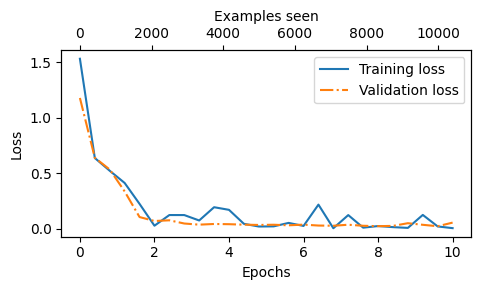

In [54]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

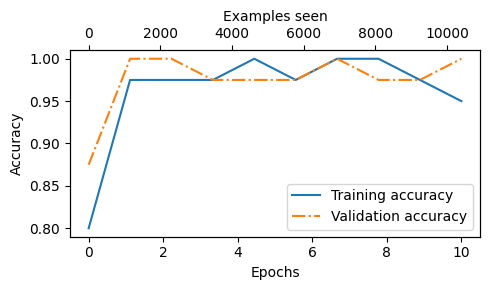

In [55]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

In [41]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 98.46%
Validation accuracy: 95.97%
Test accuracy: 96.33%


In [42]:
def classify_review(text,
                    model,
                    tokenizer,
                    device,
                    max_length=None,
                    pad_token_id=50256):
  model.eval()

  # input preprocessing
  input_ids = tokenizer.encode(text)
  supported_context_length = model.position_emb.weight.shape[0]
  input_ids = input_ids[:min(max_length, supported_context_length)]
  input_ids += [pad_token_id] * (max_length  - len(input_ids))
  input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0)

  # model inference
  with torch.no_grad():
    logits = model(input_tensor)[:, -1, :] # logits of the last output token
  predicted_label = torch.argmax(logits, dim=-1).item()

  # return the classifier result
  return "spam" if predicted_label == 1 else "not spam"

In [43]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

spam


In [44]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

print(classify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

not spam


In [45]:
# save model state_dict
torch.save(model.state_dict(), "classification_finetune_gpt2.pth")

In [46]:
# load model state_dict
model = GPT2Model(BASE_CONFIG)
num_classes = 2
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("classification_finetune_gpt2.pth", map_location=device, weights_only=True))
model.eval()

GPT2Model(
  (token_emb): Embedding(50257, 768)
  (position_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (output_projection): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (feed_forward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (layer_norm1): LayerNorm()
      (layer_norm2): LayerNorm()
      (drop_skip): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (attention): Mult

## 2.2 Gradio

In [51]:
import time
import torch

tokenizer = tiktoken.get_encoding("gpt2")

def generate_answer(input_prompt):

  # start the timer
  start_time = time.time()

  torch.manual_seed(211)

  model.eval()

  prediction = classify_review(input_prompt,
                              model,
                              tokenizer,
                              "cpu",
                              max_length=120)

  # Calculate the prediction time
  pred_time = round(time.time() - start_time, 5)

  # print("Output text:\n", token_ids_to_text(token_ids, bpe_tokenizer))
  return prediction, pred_time

In [58]:
import gradio as gr

examples = [
    ["Well done ENGLAND! Get the official poly ringtone or colour flag on yer mob"
    "ile! text TONE or FLAG to 84199 NOW! Opt-out txt ENG STOP. Box39822 W111WX £1.50"], #spam
    ["Hi its in durban are you still on this number"], #ham
    ["Compliments to you. Was away from the system. How your side."], #ham
    ["Can ü call me at 10:10 to make sure dat i've woken up..."], #ham
    ["tddnewsletter@emc1.co.uk (More games from TheDailyDraw) Dear Helen,"
    " Dozens of Free Games - with great prizesWith.."], #spam

]




with gr.Blocks() as demo:
  gr.Markdown("# GPT2 From Scratch")

  # tab 1
  with gr.Tab("Instruction Finetune GPT2 (124M)"):
    with gr.Row():
      inp = gr.Textbox(label="Input Text", placeholder="Type here...")
      out = [gr.Textbox(label="Classification", value="", interactive=False),
            gr.Number(label="Time Taken (s)"),
            ]
    inp.change(fn=generate_answer, inputs=inp, outputs=out)

    with gr.Column():
      gr.Examples(examples=examples, inputs=inp, label="📚 Examples")


  # tab 2
  with gr.Tab("Graphs:"):
    with gr.Row():
      gr.Image(value="classification_finetune_loss_gpt2.png", label="Loss Curve", interactive=False)
      gr.Image(value="classification_finetune_accuracy_gpt2.png", label="Accuracy", interactive=False)







# Launch the demo!
demo.launch(debug=True, # print errors locally?
            share=True) # generate a publically shareable URL?

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://0db78a2b143fac0f84.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://0db78a2b143fac0f84.gradio.live
